In [1]:
import importlib
import Functions_23_Avino_Lombardi
importlib.reload(Functions_23_Avino_Lombardi)
from Functions_23_Avino_Lombardi import *
import sys
sys.path.append("../Question 2")
from Functions_22_Avino_Lombardi import *


📌 SMO with Polynomial Kernel (p=2)
   C = 1.0, p = 2, tol = 0.001

✅ Accuracy Train: 0.9250
✅ Accuracy Test : 0.8900
📊 Confusion Matrix:
[[88 13]
 [ 9 90]]
💡 Dual objective value: -121.8576
📉 Final difference m(λ)-M(λ): -120.291725
🔁 Iterazioni: 1354
⏱ Tempo di addestramento SMO: 56.50 sec
🎯 Support vectors: 277


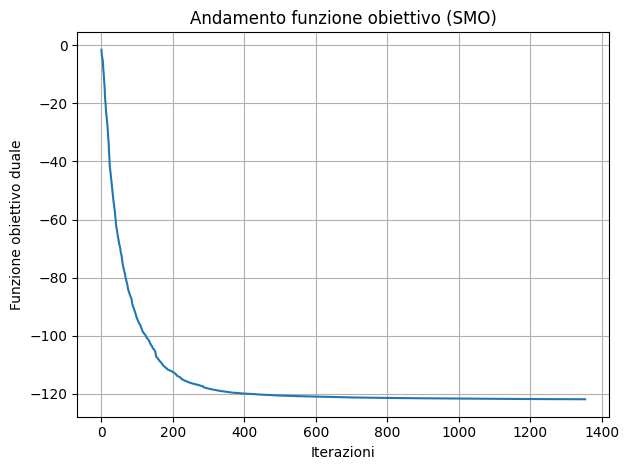


⚙️ Sklearn SVC Accuracy: 0.9000
📌 Support vectors (SVC): 387


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import time

# === KERNEL: Polynomial ===
def polynomial_kernel(X1, X2, p=2):
    return (1 + X1 @ X2.T) ** p

# === SMO Predict ===
def smo_predict(X_train, y_train, alpha, b, X_test, p):
    K = polynomial_kernel(X_test, X_train, p)
    return np.sign((alpha * y_train) @ K.T + b)

# === SMO Train (modifica per restituire anche m-M e n_iter) ===
def smo_train(X, y, C=1.0, p=2, tol=1e-3, max_iter=5000):
    n = len(y)
    alpha = np.zeros(n)
    b = 0
    K = polynomial_kernel(X, X, p)
    obj_values = []
    for it in range(max_iter):
        alpha_prev = np.copy(alpha)
        for i in range(n):
            j = np.random.randint(0, n)
            while j == i:
                j = np.random.randint(0, n)

            xi, xj = X[i], X[j]
            yi, yj = y[i], y[j]
            kii = K[i, i]
            kjj = K[j, j]
            kij = K[i, j]

            eta = 2 * kij - kii - kjj
            if eta >= 0:
                continue

            Ei = (alpha * y) @ K[:, i] + b - yi
            Ej = (alpha * y) @ K[:, j] + b - yj

            alpha_j_new = alpha[j] - yj * (Ei - Ej) / eta
            if yi != yj:
                L = max(0, alpha[j] - alpha[i])
                H = min(C, C + alpha[j] - alpha[i])
            else:
                L = max(0, alpha[i] + alpha[j] - C)
                H = min(C, alpha[i] + alpha[j])

            if L == H:
                continue
            alpha_j_new = np.clip(alpha_j_new, L, H)
            alpha_i_new = alpha[i] + yi * yj * (alpha[j] - alpha_j_new)

            # Aggiornamento alpha e b
            alpha[i], alpha[j] = alpha_i_new, alpha_j_new

            b1 = b - Ei - yi * (alpha[i] - alpha_i_new) * kii - yj * (alpha[j] - alpha_j_new) * kij
            b2 = b - Ej - yi * (alpha[i] - alpha_i_new) * kij - yj * (alpha[j] - alpha_j_new) * kjj
            b = (b1 + b2) / 2

        diff = np.linalg.norm(alpha - alpha_prev)
        dual_obj = - np.sum(alpha) + 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K)
        obj_values.append(dual_obj)
        if diff < tol:
            break

    mM_diff = 0 if len(obj_values) < 2 else obj_values[-1] - obj_values[0]
    return alpha, b, obj_values, mM_diff, it + 1  # restituisco anche #iterazioni

# === STEP 1: CARICAMENTO DATI ===
data = pd.read_csv("../dataset/GENDER_CLASSIFICATION.csv")
X = data.iloc[:, :-1].values
y = np.where(data.iloc[:, -1].values == 0, -1, 1)

# === STEP 2: PREPROCESSING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === STEP 3: ALLENAMENTO SMO ===
C = 1.0
p = 2
tol = 1e-3

print("\n📌 SMO with Polynomial Kernel (p=2)")
print(f"   C = {C}, p = {p}, tol = {tol}")

start = time.time()
alpha, b, obj_values, diff_mM, n_iter = smo_train(X_train, y_train, C=C, p=p, tol=tol)
end = time.time()
exec_time = end - start

# === STEP 4: PREDIZIONE ===
y_train_pred = smo_predict(X_train, y_train, alpha, b, X_train, p)
y_test_pred = smo_predict(X_train, y_train, alpha, b, X_test, p)

# === STEP 5: RISULTATI ===
print(f"\n✅ Accuracy Train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"✅ Accuracy Test : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"📊 Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"💡 Dual objective value: {obj_values[-1]:.4f}")
print(f"📉 Final difference m(λ)-M(λ): {diff_mM:.6f}")
print(f"🔁 Iterazioni: {n_iter}")
print(f"⏱ Tempo di addestramento SMO: {exec_time:.2f} sec")
print(f"🎯 Support vectors: {np.sum(alpha > 1e-5)}")

# === STEP 6: PLOT FUNZIONE OBIETTIVO ===
plt.plot(obj_values)
plt.xlabel("Iterazioni")
plt.ylabel("Funzione obiettivo duale")
plt.title("Andamento funzione obiettivo (SMO)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 7: CONFRONTO CON SCIKIT-LEARN ===
svc = SVC(C=1.0, kernel='poly', degree=2)
svc.fit(X_train, y_train)
y_sklearn_pred = svc.predict(X_test)

print(f"\n⚙️ Sklearn SVC Accuracy: {accuracy_score(y_test, y_sklearn_pred):.4f}")
print(f"📌 Support vectors (SVC): {svc.support_.shape[0]}")


⚙️ Hyperparameters:
   C = 1.0, gamma = 0.1, tol = 0.001

⏱ Tempo di ottimizzazione: 32.20 sec
🔁 Numero di iterazioni: 1112
🎯 Valore finale funzione obiettivo duale: 132.709775

✅ Accuracy Train: 0.9225
✅ Accuracy Test : 0.9000
🎯 Support vectors (α > 1e-5): 168

📊 Confusion Matrix (Test):
[[90 11]
 [ 9 90]]


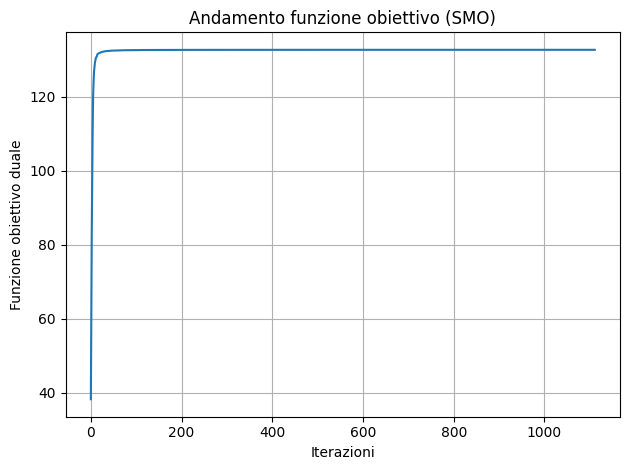


⚙️ Scikit-learn SVC Accuracy: 0.9000
📌 Support vectors (SVC): 163


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import time

def rbf_kernel(X1, X2, gamma):
    """RBF kernel"""
    if X1.ndim == 1:
        X1 = X1[np.newaxis, :]
    if X2.ndim == 1:
        X2 = X2[np.newaxis, :]
    sq_dists = np.sum(X1**2, axis=1)[:, None] + np.sum(X2**2, axis=1)[None, :] - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

def smo_train(X, y, C=1.0, tol=1e-3, max_passes=5, gamma=0.5):
    """SMO semplificato (Platt 1998)"""
    n = X.shape[0]
    alpha = np.zeros(n)
    b = 0
    passes = 0
    K = rbf_kernel(X, X, gamma)
    obj_values = []

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(n):
            E_i = b + np.sum(alpha * y * K[:, i]) - y[i]
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                j = np.random.choice([x for x in range(n) if x != i])
                E_j = b + np.sum(alpha * y * K[:, j]) - y[j]

                alpha_i_old, alpha_j_old = alpha[i], alpha[j]

                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue

                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)

                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue

                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])

                b1 = b - E_i - y[i]*(alpha[i] - alpha_i_old)*K[i, i] - y[j]*(alpha[j] - alpha_j_old)*K[i, j]
                b2 = b - E_j - y[i]*(alpha[i] - alpha_i_old)*K[i, j] - y[j]*(alpha[j] - alpha_j_old)*K[j, j]

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_changed_alphas += 1

        # Salva valore funzione obiettivo duale
        obj_val = np.sum(alpha) - 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K)
        obj_values.append(obj_val)

        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    return alpha, b, obj_values

def smo_predict(X_train, y_train, alpha, b, X_test, gamma=0.5):
    K = rbf_kernel(X_test, X_train, gamma)
    return np.sign(K @ (alpha * y_train) + b)

# === STEP 1: CARICAMENTO DATI ===
data = pd.read_csv("../dataset/GENDER_CLASSIFICATION.csv")
X = data.iloc[:, :-1].values
y = np.where(data.iloc[:, -1].values == 0, -1, 1)

# === STEP 2: PREPROCESSING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === STEP 3: ALLENAMENTO SMO ===
C = 1.0
gamma = 0.1
tol = 1e-3

print("⚙️ Hyperparameters:")
print(f"   C = {C}, gamma = {gamma}, tol = {tol}")

start = time.time()
alpha, b, obj_values = smo_train(X_train, y_train, C=C, gamma=gamma, tol=tol)
end = time.time()
exec_time = end - start

print(f"\n⏱ Tempo di ottimizzazione: {exec_time:.2f} sec")
print(f"🔁 Numero di iterazioni: {len(obj_values)}")
print(f"🎯 Valore finale funzione obiettivo duale: {obj_values[-1]:.6f}")

# === STEP 4: PREDIZIONE ===
y_train_pred = smo_predict(X_train, y_train, alpha, b, X_train, gamma=gamma)
y_test_pred = smo_predict(X_train, y_train, alpha, b, X_test, gamma=gamma)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Accuracy Train: {acc_train:.4f}")
print(f"✅ Accuracy Test : {acc_test:.4f}")
print(f"🎯 Support vectors (α > 1e-5): {np.sum(alpha > 1e-5)}")
print(f"\n📊 Confusion Matrix (Test):\n{confusion_matrix(y_test, y_test_pred)}")

# === STEP 5: PLOT FUNZIONE OBIETTIVO ===
plt.figure()
plt.plot(obj_values)
plt.xlabel("Iterazioni")
plt.ylabel("Funzione obiettivo duale")
plt.title("Andamento funzione obiettivo (SMO)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 6: CONFRONTO CON SCIKIT-LEARN ===
svc = SVC(C=C, gamma=gamma, kernel='rbf')
svc.fit(X_train, y_train)
y_sklearn_pred = svc.predict(X_test)

print(f"\n⚙️ Scikit-learn SVC Accuracy: {accuracy_score(y_test, y_sklearn_pred):.4f}")
print(f"📌 Support vectors (SVC): {svc.support_.shape[0]}")